In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/DeepLearning/PowerProp/'

/content/drive/MyDrive/DeepLearning/PowerProp


In [3]:
%ls

cifar_training.ipynb  mnist_training.ipynb  scripts/
images/               powerprop.py          utils/


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'You are using device: {device}')

You are using device: cuda


In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

from utils import utils as uu
from utils.loading import load_data
from utils.pp_modules import CNN


model_seed = 0
torch.manual_seed(model_seed)

In [7]:
# Training Configuration

dataset = 'CIFAR10'
alphas = [1.0, 2.0, 3.0] # only 3 alphas, not 5
report_interval = 2500

# Training Hyperparameters
train_batch_size = 60
num_train_steps = 100000
learning_rate = 0.1
momentum = 0.0

# load data
train_x, train_y = load_data(dataset, train=True)
test_x, test_y = load_data(dataset, train=False)

train_x = train_x.to(device)
test_x = test_x.to(device)
train_y = train_y.to(device)
test_y = test_y.to(device)

epochs = int(num_train_steps * train_batch_size / train_x.shape[0])
print(epochs)
dataloader = DataLoader(TensorDataset(train_x, train_y), batch_size=train_batch_size, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified
120


In [8]:
def prune_by_magnitude(percent_to_keep, weight):
    condition = torch.abs(weight.flatten())
    how_many = int(percent_to_keep * torch.numel(condition))
    top_k = torch.topk(condition, k=how_many)

    mask = torch.zeros(condition.shape).to(device)
    mask[top_k.indices] = 1

    return mask.reshape(weight.shape)


def evaluate_pruning(model, test_x, test_y, criterion):
    final_weights = model.get_weights()
    sparsity_levels = np.geomspace(0.01, 1.0, 20).tolist()
    acc_at_sparsity = []
    for p_to_use in sparsity_levels:
        # Half the sparsity at output layer
        percent = [p_to_use] * 8 + [min(1.0, p_to_use * 2.0)]
        masks = []
        for p, w in zip(percent, final_weights):
            masks.append(prune_by_magnitude(p, w))

        loss, acc = uu.evaluate(model, test_x, test_y, criterion, masks=masks)
        acc_at_sparsity.append(acc)

    return acc_at_sparsity

In [9]:
model_types = []
for alpha in alphas:
    if alpha > 1.0:
        model_types.append('Powerprop. ($\\alpha={}$)'.format(alpha))
    else:
        model_types.append('Baseline')

In [ ]:
# repetitions = 5
# total_results = []
# total_weights = []
# final_models = []
# batches = len(dataloader)
# steps = epochs * batches
# for r in range(repetitions):
#     print(f'Repetition {r + 1}')
#     rep_results = []
#     rep_weights = {}
#     models = [CNN(alpha=alpha).to(device) for alpha in alphas]
#     optims = [torch.optim.SGD(m.parameters(), lr=learning_rate, momentum=momentum) for m in models]
#     losses = [torch.nn.CrossEntropyLoss() for _ in range(len(models))]

#     for model in models:
#         model.apply(uu.init_weights)
#         model.train()

#     with torch.no_grad():
#         rep_weights['initial'] = [m.get_weights() for m in models]

#     for epoch in range(epochs):
#         for i, (data, targets) in enumerate(dataloader, start=epoch * batches):
#             for model, optim, loss in zip(models, optims, losses):
#                 optim.zero_grad()
#                 out = model(data)
#                 loss_val = loss(out, targets)
#                 loss_val.backward()
#                 optim.step()

#             if i % report_interval == 0:
#                 print(f'Epoch: [{epoch + 1}/{epochs}][{i}/{steps}]\t')

#     # last 40 training steps
#     for i, (data, targets) in enumerate(dataloader):
#         if i == 40:
#             break
#         for model, optim, loss in zip(models, optims, losses):
#             optim.zero_grad()
#             out = model(data)
#             loss_val = loss(out, targets)
#             loss_val.backward()
#             optim.step()

#     with torch.no_grad():
#         rep_weights['final'] = [m.get_weights() for m in models]

#     for model, loss in zip(models, losses):
#         pruning_accs = evaluate_pruning(model, test_x, test_y, loss)
#         rep_results.append(pruning_accs)
    
#     total_results.append(rep_results)
#     total_weights.append(rep_weights)
#     final_models.append(models)

Repetition 1
Epoch: [1/120][0/99960]	
Epoch: [4/120][2500/99960]	


In [10]:
results = []
weights = {}
batches = len(dataloader)
steps = epochs * batches

models = [CNN(alpha=alpha).to(device) for alpha in alphas]
optims = [torch.optim.SGD(m.parameters(), lr=learning_rate, momentum=momentum) for m in models]
losses = [torch.nn.CrossEntropyLoss() for _ in range(len(models))]

for model in models:
    model.apply(uu.init_weights)
    model.train()

with torch.no_grad():
    weights['initial'] = [m.get_weights() for m in models]

for epoch in range(epochs):
    for i, (data, targets) in enumerate(dataloader, start=epoch * batches):
        for model, optim, loss in zip(models, optims, losses):
            optim.zero_grad()
            out = model(data)
            loss_val = loss(out, targets)
            loss_val.backward()
            optim.step()

        if i % report_interval == 0:
            print(f'Epoch: [{epoch + 1}/{epochs}][{i}/{steps}]\t')

# last 40 training steps
for i, (data, targets) in enumerate(dataloader):
    if i == 40:
        break
    for model, optim, loss in zip(models, optims, losses):
        optim.zero_grad()
        out = model(data)
        loss_val = loss(out, targets)
        loss_val.backward()
        optim.step()

with torch.no_grad():
    weights['final'] = [m.get_weights() for m in models]

Epoch: [1/120][0/99960]	
Epoch: [4/120][2500/99960]	
Epoch: [7/120][5000/99960]	
Epoch: [10/120][7500/99960]	
Epoch: [13/120][10000/99960]	
Epoch: [16/120][12500/99960]	
Epoch: [19/120][15000/99960]	
Epoch: [22/120][17500/99960]	
Epoch: [25/120][20000/99960]	
Epoch: [28/120][22500/99960]	
Epoch: [31/120][25000/99960]	
Epoch: [34/120][27500/99960]	
Epoch: [37/120][30000/99960]	
Epoch: [40/120][32500/99960]	
Epoch: [43/120][35000/99960]	
Epoch: [46/120][37500/99960]	
Epoch: [49/120][40000/99960]	
Epoch: [52/120][42500/99960]	
Epoch: [55/120][45000/99960]	
Epoch: [58/120][47500/99960]	
Epoch: [61/120][50000/99960]	
Epoch: [64/120][52500/99960]	
Epoch: [67/120][55000/99960]	
Epoch: [70/120][57500/99960]	
Epoch: [73/120][60000/99960]	
Epoch: [76/120][62500/99960]	
Epoch: [79/120][65000/99960]	
Epoch: [82/120][67500/99960]	
Epoch: [85/120][70000/99960]	
Epoch: [88/120][72500/99960]	
Epoch: [91/120][75000/99960]	
Epoch: [94/120][77500/99960]	
Epoch: [97/120][80000/99960]	
Epoch: [100/120][825

TypeError: ignored

In [12]:
# save final model states
for i in range(len(models)):
    torch.save(models[i].state_dict(), f'./images/cifar_final_model_alpha{i}_lr01_m0.pt')

In [12]:
models = [CNN(alpha=alpha).to(device) for alpha in alphas]
losses = [torch.nn.CrossEntropyLoss() for _ in range(len(models))]

for i, model in enumerate(models):
  model.load_state_dict(torch.load(f'./images/cifar_final_model_alpha{i}_lr01_m0.pt'))
  model.eval()

In [13]:
results = []
for model, loss in zip(models, losses):
    pruning_accs = evaluate_pruning(model, test_x, test_y, loss)
    results.append(pruning_accs)

In [ ]:
for p_to_use in np.geomspace(0.01, 1.0, 20):
    # Half the sparsity at output layer
    percent = 2*[p_to_use] + [min(1.0, p_to_use*2)]
    for m_id, model in enumerate(models):
        masks = []
        for i, w in enumerate(weights['final'][m_id]):
            masks.append(prune_by_magnitude(percent[i], w))

        loss, acc = uu.evaluate(model, test_x, test_y, losses[m_id], masks=masks)
        print('Performance @ {:1.0f}% of weights [Alpha {}]: Acc {:1.3f} Loss {:1.3f} '.format(
            100*p_to_use, alphas[m_id], acc, loss))

In [14]:
len(results)

3

In [18]:
np.array(results).dtype

dtype('float64')

In [22]:
final_weights = []
initial_weights = []

for w in weights['final']:
  for i in range(3):
    final_weights.append(w[i].cpu().numpy())

for w in weights['initial']:
  for i in range(3):
    initial_weights.append(w[i].cpu().numpy())

In [19]:
# save weights just to avoid repeated training

# np.save(r'./images/cifar_final_weights_lr0025_m9_FINAL.npy', np.array(final_weights))
# np.save(r'./images/cifar_initial_weights_lr0025_m9_FINAL.npy', np.array(initial_weights))
np.save(r'./images/cifar_sparsity_performance_lr0025_m9_FINAL.npy', np.array(results))

In [21]:
arr = np.array(results)
# means = arr.mean(axis=0)
# stds = arr.std(axis=0)

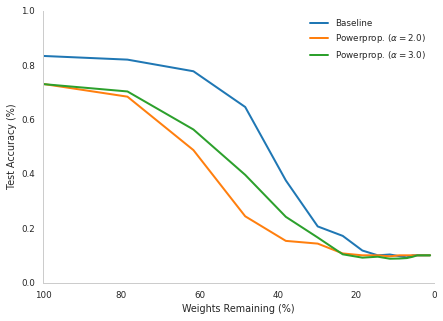

In [27]:
sns.set_style("whitegrid")
sns.set_context("paper")

sparsity_levels = 100 * np.geomspace(0.01, 1.0, 20)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, label in enumerate(model_types):
    # ax.errorbar(sparsity_levels, means[i], yerr=stds[i], label=label, lw=2)
    ax.plot(sparsity_levels, arr[i], label=label, lw=2)

ax.set_xlim([100.0, 0.0])
ax.set_ylim([0.0, 1.0])
ax.legend(frameon=False)
ax.grid(False)
# ax.set_xticks([35, 30, 25, 20, 15, 10, 5, 1])
ax.set_xlabel('Weights Remaining (%)')
ax.set_ylabel('Test Accuracy (%)')

sns.despine()
f.savefig('images/cifar_sparsity_performance_lr0025_m9_grid_off_FINAL.png')

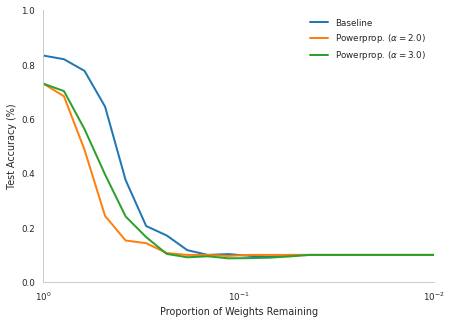

In [28]:
sns.set_style("whitegrid")
sns.set_context("paper")

sparsity_levels = np.geomspace(0.01, 1.0, 20)

f, ax = plt.subplots(1, 1, figsize=(7, 5))
for i, label in enumerate(model_types):
    # ax.errorbar(sparsity_levels, means[i], yerr=stds[i], label=label, lw=2)
    ax.plot(sparsity_levels, arr[i], label=label, lw=2)

ax.set_xscale('log')
ax.set_xlim([1.0, 0.01])
ax.set_ylim([0.0, 1.0])
ax.legend(frameon=False)
ax.grid(False)
ax.set_xlabel('Proportion of Weights Remaining')
ax.set_ylabel('Test Accuracy (%)')

sns.despine()
f.savefig('images/cifar_sparsity_performance_log_lr0025_m9_FINAL.png')